In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Llegim el nom dels nodes.
# Obrim el fitxer '.txt' i  llegim les linies.
with open('mindboggle_ROIs_class.txt', 'r') as file:
    header_line = file.readline().strip()

    data = []

    for line in file:
        values = line.strip().split('\t')
        data.append(values)

dict_data = dict()
for i in data:
    node=int(i[0])-1
    dict_data[str(node)] = i[1]
#dict_data

In [3]:
# Read CSV File.
df = pd.read_csv('clinic_data_oversampled.csv')
df.head()


,Unnamed: 0,Unnamed: 0.1,id,redcap_event_name,controls_ms,dob,msonset,nrldate,age,sex,...,assortativity_m,betweenness_centrality_m,global_efficiency_m,local_efficiency_m,transitivity_m,modularity_m,matrix,corrected_matrix_functional,corrected_matrix_structural,corrected_matrix_morphological
0,0,0.0,002MSVIS,year3_arm_1,1,1963-09-04,1993-01-10,2015-03-16,51.53,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 0.32851901 0.37493742 -0.39139019 ... 0.52...,[ 0.39740076 -0.09341676 0. ... 0.34...,[0.00977906 0.0100095 0.00361605 ... 0.018132...
1,1,1.0,003MSVIS,year5_arm_1,1,1959-01-18,2007-07-15,2017-02-08,58.06,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[-0.31202184 0.08207223 0.11594658 ... 0.63...,[ 0.27083918 -0.09214492 0. ... 0.29...,[0.01129104 0.00431982 0.00196747 ... 0.038036...
2,2,2.0,004MSVIS,year5_arm_1,1,1956-09-16,2010-09-15,2017-06-29,60.78,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 1.08407935 -0.67898178 1.1044498 ... 0.45...,[ 0.44913222 -0.10735491 0. ... 0.35...,[0.02831956 0.02485665 0.01373529 ... 0.074084...
3,3,3.0,005MSVIS,year5_arm_1,1,1978-02-01,2007-08-01,2016-01-13,37.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.45321475 0.18308231 0.64934064 ... 0.356658...,[ 0.35528808 -0.06184264 0. ... 0.48...,[0.02394986 0.01935932 0.00672023 ... 0.052758...
4,4,4.0,010MSVIS,year5_arm_1,1,1964-02-13,2007-09-15,2016-10-04,52.64,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[-0.17881511 -0.32504304 0.26268199 ... 0.24...,[ 0.31603542 -0.08397792 0. ... 0.34...,[0.025553 0.0113439 0.00735928 ... 0.047532...


In [4]:
type_data = '_r_matrix.csv' # Functional data
#type_data = '_FA_factor.csv' # Structural data
#type_data = '_GM_matrix.csv' # Morphological data

folder_type = 'Functional'
#folder_type = 'Structural'
#folder_type = 'Morphological'

patients_MS = list()
controls_HV = list()
patients_MS_dict = dict()
controls_HV_dict = dict()

# Afegim columna matrix.
df['matrix'] = None

# S'iteren totes les matrius.
for index, row in df.iterrows():
    # Llegim la matriu.
    matrix = pd.read_csv(
        f'/home/guillem/Desktop/Data_Science/TFM/data/MULTILAYER/test_Zeros_Undersampling/{folder_type}/{row["id"]}{type_data}', 
        header=None
    )
    
    df.at[index, 'matrix'] = matrix
    
    if row['controls_ms'] == 1:
        patients_MS.append(matrix)
        patients_MS_dict[f"{row['id']}"] = matrix
    else:
        controls_HV.append(matrix)
        controls_HV_dict[f"{row['id']}"] = matrix


In [5]:
# Considerar cada NODE com una característica del model.
# Eliminem les connexions que no mostrin un pvalue significatiu (diferencies significatives entre MS i HV).
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

alpha = 0.05
num_matrius = len(df)
significative_matrix = np.zeros((76, 76))
llistat_columnes_analitzar = list()
dades_columnes_analitzar = dict()

# Se iteran todos los nodos.
for i in range(0, 76):  # Per cada característica
    # Se iteran todos los nodos para comparar.
    for j in range(i+1, 76):
        dades_HV = [matrix.iloc[i][j] for matrix in df[df['controls_ms'] == 0]['matrix']]
        #dades_HV_ids = [ID for ID in controls_HV_dict]
        dades_MS = [matrix.iloc[i][j] for matrix in df[df['controls_ms'] == 1]['matrix']]
        #dades_MS_ids = [ID for ID in patients_MS_dict]

        stat_pacients, p_pacients = shapiro(dades_HV)
        stat_controls, p_controls = shapiro(dades_MS)
        
        # Si compleixen una distribució normal.
        if p_pacients > alpha and p_controls > alpha:
            stat, p = ttest_ind(dades_HV, dades_MS)

        # En cas de que no compleixin una distribució normal.
        else:
            stat, p = mannwhitneyu(dades_HV, dades_MS)
        
        # Aplica la correcció de Bonferroni
        p_corregit = p * num_matrius#min([len(dades_HV), len(dades_MS)])
        
        #if p <= alpha:
            #print(f"La característica {i}-{j} té una diferència significativa (p corregit: {p_corregit}).")
            #significative_matrix[i][j] = np.mean(dades_HV) - np.mean(dades_MS)
            #llistat_columnes_analitzar.append(f"{i}-{j}")
            #dades_columnes_analitzar[f"{i}-{j}"] = dades_HV + dades_MS
        if p_corregit <= alpha:
            print(f"La característica {i}-{j} té una diferència significativa (p corregit: {p_corregit}).")
            significative_matrix[i][j] = np.mean(dades_HV) - np.mean(dades_MS)
            llistat_columnes_analitzar.append(f"{i}-{j}")
            dades_columnes_analitzar[f"{i}-{j}"] = dades_HV + dades_MS
        #else:
            # En cas de que no hi hagi significancia en la connexió i-j, s'elimina la connexió dels controls_HV i pacients_MS.
            #for matrix in controls_HV:
            #    matrix[i][j] = 0
            #for matrix in patients_MS:
            #    matrix[i][j] = 0


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 0-53 té una diferència significativa (p corregit: 0.0025005698139530116).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 0-64 té una diferència significativa (p corregit: 0.04496786776935455).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 1-11 té una diferència significativa (p corregit: 0.00028773012878178237).
La característica 1-26 té una diferència significativa (p corregit: 2.370932918085581e-07).
La característica 1-28 té una diferència significativa (p corregit: 0.01787651690712129).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 1-46 té una diferència significativa (p corregit: 0.03737317542892686).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 1-59 té una diferència significativa (p corregit: 0.009932713030259563).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 1-65 té una diferència significativa (p corregit: 0.0008462846601113021).
La característica 1-66 té una diferència significativa (p corregit: 0.0010067509632812083).
La característica 1-69 té una diferència significativa (p corregit: 0.012623760150102628).
La característica 1-71 té una diferència significativa (p corregit: 0.01309108200927064).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 2-37 té una diferència significativa (p corregit: 0.02203601202959392).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 2-52 té una diferència significativa (p corregit: 0.008581567447049424).
La característica 2-56 té una diferència significativa (p corregit: 0.002423672101851983).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 2-67 té una diferència significativa (p corregit: 0.0024096884977544758).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 3-11 té una diferència significativa (p corregit: 0.04749792023459429).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 3-30 té una diferència significativa (p corregit: 1.3103612760541113e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 3-56 té una diferència significativa (p corregit: 9.480913910577601e-07).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 4-6 té una diferència significativa (p corregit: 0.003126566575539521).
La característica 4-8 té una diferència significativa (p corregit: 0.022381652111936864).
La característica 4-10 té una diferència significativa (p corregit: 0.011897130820494251).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 4-37 té una diferència significativa (p corregit: 0.0007833226722661254).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 4-54 té una diferència significativa (p corregit: 0.04187413177803576).
La característica 4-56 té una diferència significativa (p corregit: 0.0011547094605818416).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 5-7 té una diferència significativa (p corregit: 0.007211340120356075).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 5-12 té una diferència significativa (p corregit: 0.00594370044208957).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 5-22 té una diferència significativa (p corregit: 0.0016063845829794817).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 6-10 té una diferència significativa (p corregit: 0.012428142241858018).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 6-37 té una diferència significativa (p corregit: 0.0010368186173450515).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 6-42 té una diferència significativa (p corregit: 6.790696357093074e-07).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 6-51 té una diferència significativa (p corregit: 0.03346088280404787).
La característica 6-56 té una diferència significativa (p corregit: 0.025419299628327167).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 7-20 té una diferència significativa (p corregit: 9.720450683105597e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 8-10 té una diferència significativa (p corregit: 0.017246446306243394).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 8-44 té una diferència significativa (p corregit: 0.013533839918819532).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 8-53 té una diferència significativa (p corregit: 2.0988562358457384e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 8-66 té una diferència significativa (p corregit: 0.008078114829210234).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 9-16 té una diferència significativa (p corregit: 0.012496039693111789).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 9-36 té una diferència significativa (p corregit: 0.00042849231023660137).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 9-55 té una diferència significativa (p corregit: 0.0013932166071978717).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 10-14 té una diferència significativa (p corregit: 0.00202482646982609).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 10-56 té una diferència significativa (p corregit: 6.320438177534589e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 11-32 té una diferència significativa (p corregit: 0.028855577648125186).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 12-18 té una diferència significativa (p corregit: 0.00012926593629987684).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 12-28 té una diferència significativa (p corregit: 0.045553251917067675).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 12-36 té una diferència significativa (p corregit: 5.8622832463151996e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 13-54 té una diferència significativa (p corregit: 0.0027013935003713627).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 13-69 té una diferència significativa (p corregit: 6.628306434592855e-08).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 14-18 té una diferència significativa (p corregit: 0.0073293983227083245).
La característica 14-19 té una diferència significativa (p corregit: 5.323845790893413e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 15-17 té una diferència significativa (p corregit: 0.0006372395349375356).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 15-24 té una diferència significativa (p corregit: 0.029228274176739098).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 16-17 té una diferència significativa (p corregit: 1.1544014280451968e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 16-23 té una diferència significativa (p corregit: 3.3486334421264465e-08).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 16-56 té una diferència significativa (p corregit: 0.002373267812294464).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 16-75 té una diferència significativa (p corregit: 0.015137048028547859).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 17-23 té una diferència significativa (p corregit: 0.0005222632670238226).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 18-19 té una diferència significativa (p corregit: 0.012529538947389101).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 18-26 té una diferència significativa (p corregit: 0.04952602088202159).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 19-21 té una diferència significativa (p corregit: 0.004369565026646737).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 19-26 té una diferència significativa (p corregit: 4.021177596146867e-05).
La característica 19-29 té una diferència significativa (p corregit: 0.00031841991362693644).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 19-47 té una diferència significativa (p corregit: 0.004306025801567596).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 19-60 té una diferència significativa (p corregit: 3.570022646669025e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 19-69 té una diferència significativa (p corregit: 0.008032781262289013).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 20-22 té una diferència significativa (p corregit: 5.827870030911603e-08).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 21-29 té una diferència significativa (p corregit: 0.012679698984130704).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 21-60 té una diferència significativa (p corregit: 0.025185437316152092).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 21-69 té una diferència significativa (p corregit: 0.0004275009510481431).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 22-50 té una diferència significativa (p corregit: 0.000784165026222063).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 23-24 té una diferència significativa (p corregit: 0.00012045853962705214).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 23-57 té una diferència significativa (p corregit: 0.03654807506649233).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 23-64 té una diferència significativa (p corregit: 9.076048640848625e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 23-74 té una diferència significativa (p corregit: 8.730254812994698e-07).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 24-54 té una diferència significativa (p corregit: 0.0026262070567683563).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 25-56 té una diferència significativa (p corregit: 0.009475152529772015).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 25-61 té una diferència significativa (p corregit: 0.0008871341936152413).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 26-28 té una diferència significativa (p corregit: 0.008488514721868633).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 30-45 té una diferència significativa (p corregit: 0.022080133345011427).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 31-68 té una diferència significativa (p corregit: 0.005693269617650459).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 31-73 té una diferència significativa (p corregit: 0.001509147513990771).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 32-64 té una diferència significativa (p corregit: 2.593250378421088e-07).
La característica 32-68 té una diferència significativa (p corregit: 9.289206004742429e-08).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 32-75 té una diferència significativa (p corregit: 0.0066146100774525885).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 34-74 té una diferència significativa (p corregit: 5.994308547285567e-08).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 35-54 té una diferència significativa (p corregit: 0.0011771145660412882).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 36-51 té una diferència significativa (p corregit: 0.04646321249855656).
La característica 36-54 té una diferència significativa (p corregit: 0.00024109319671321592).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 37-47 té una diferència significativa (p corregit: 0.0407424675591822).
La característica 37-51 té una diferència significativa (p corregit: 0.030298298468744125).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 37-57 té una diferència significativa (p corregit: 0.0010940472636917528).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 37-67 té una diferència significativa (p corregit: 3.5928638792481e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 38-68 té una diferència significativa (p corregit: 0.010497703178598347).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 38-73 té una diferència significativa (p corregit: 0.0009694441991691202).
La característica 38-74 té una diferència significativa (p corregit: 0.004097572735654491).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 39-68 té una diferència significativa (p corregit: 9.424401800402575e-08).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 40-41 té una diferència significativa (p corregit: 0.00298776329743778).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 40-68 té una diferència significativa (p corregit: 0.007451088265485567).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 42-54 té una diferència significativa (p corregit: 8.442062759168132e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 42-63 té una diferència significativa (p corregit: 0.02834199649179878).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 43-54 té una diferència significativa (p corregit: 0.020253586007408928).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 43-72 té una diferència significativa (p corregit: 0.0031534687881496484).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 44-47 té una diferència significativa (p corregit: 0.0014780584942663644).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 44-63 té una diferència significativa (p corregit: 0.0004538830662182642).
La característica 44-66 té una diferència significativa (p corregit: 3.1878102529919524e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 44-72 té una diferència significativa (p corregit: 1.9659071112701044e-09).
La característica 44-74 té una diferència significativa (p corregit: 2.34459770946807e-07).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 45-58 té una diferència significativa (p corregit: 0.002196557644919723).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 46-71 té una diferència significativa (p corregit: 1.129449356938952e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 47-53 té una diferència significativa (p corregit: 0.01078277076519319).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 49-53 té una diferència significativa (p corregit: 1.2812473947002526e-05).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 50-67 té una diferència significativa (p corregit: 1.0279410156641566e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 51-57 té una diferència significativa (p corregit: 0.01053352059811903).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 53-55 té una diferència significativa (p corregit: 0.03836371740715924).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 59-69 té una diferència significativa (p corregit: 0.0059451567232136435).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 60-64 té una diferència significativa (p corregit: 0.02141440494794776).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 62-72 té una diferència significativa (p corregit: 0.041161356337254026).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 64-68 té una diferència significativa (p corregit: 0.0010698138144665372).
La característica 64-72 té una diferència significativa (p corregit: 0.015370757976954141).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 66-68 té una diferència significativa (p corregit: 9.428744778304017e-06).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats

La característica 68-74 té una diferència significativa (p corregit: 0.004805698182663022).
La característica 69-70 té una diferència significativa (p corregit: 0.023217873988090672).


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


La característica 70-75 té una diferència significativa (p corregit: 0.01874721239442892).
La característica 72-74 té una diferència significativa (p corregit: 0.03531364812257087).
La característica 73-75 té una diferència significativa (p corregit: 0.037408703994463326).
La característica 74-75 té una diferència significativa (p corregit: 2.567830582852214e-10).


In [6]:
# Afegim la columna de 'controls_ms'.
dades_columnes_analitzar['controls_ms'] = [0 for i in range(0, len(dades_HV))] + [1 for i in range(0, len(dades_MS))]
#dades_columnes_analitzar['id'] = dades_HV_ids + dades_MS_ids 

# Dict to DataFrame.
df_model_data = pd.DataFrame(dades_columnes_analitzar)
#df_model_data_merged = pd.merge(df_model_data, df, on=['id', 'controls_ms'])

# Shuffle data.
shuffled_df_model_data = df_model_data.sample(frac=1).reset_index(drop=True)
#shuffled_df_model_data = df_model_data_merged.sample(frac=1).reset_index(drop=True)

shuffled_df_model_data.head()

,0-53,0-64,1-11,1-26,1-28,1-46,1-59,1-65,1-66,1-69,...,64-68,64-72,66-68,68-74,69-70,70-75,72-74,73-75,74-75,controls_ms
0,0.225323,0.000000,0.000000,2.570584,0.752191,1.970934,1.473091,0.613669,1.575511,1.126528,...,0.000000,0.000000,0.000000,0.512687,1.051256,0.000000,0.868664,1.364936,0.619050,0
1,0.000000,0.707206,4.470589,2.485906,2.693675,0.000000,0.000000,0.384961,0.102721,0.943424,...,0.000000,1.726409,0.941184,0.874705,1.512227,0.714004,2.167052,0.957464,1.801247,0
2,0.000000,0.555908,0.000000,1.727872,1.711521,1.943729,0.000000,1.440521,0.342721,1.923140,...,1.460964,1.752867,0.000000,0.109906,0.000000,0.837975,1.422291,1.261088,2.088326,0
3,1.631798,0.000000,0.000000,0.000000,0.000000,1.562074,0.240009,0.000000,0.386438,0.000000,...,0.812199,1.283308,0.570840,1.829014,1.077738,0.334009,1.357019,1.166682,1.229761,0
4,0.000000,0.000000,2.164499,0.000000,1.941210,2.546254,0.708983,1.002496,2.038940,1.930747,...,0.000000,1.346325,0.000000,0.000000,1.346634,1.028394,1.461507,0.320785,1.544275,1


* **Connexions: RFC**

Training set - Features: (212, 126), Labels: (212,)
Testing set - Features: (53, 126) Labels: (53,)


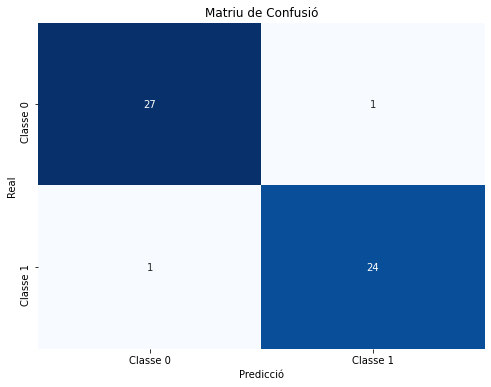

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.96      0.96      0.96        25

    accuracy                           0.96        53
   macro avg       0.96      0.96      0.96        53
weighted avg       0.96      0.96      0.96        53



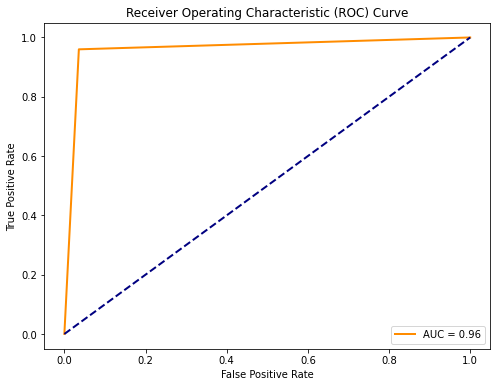

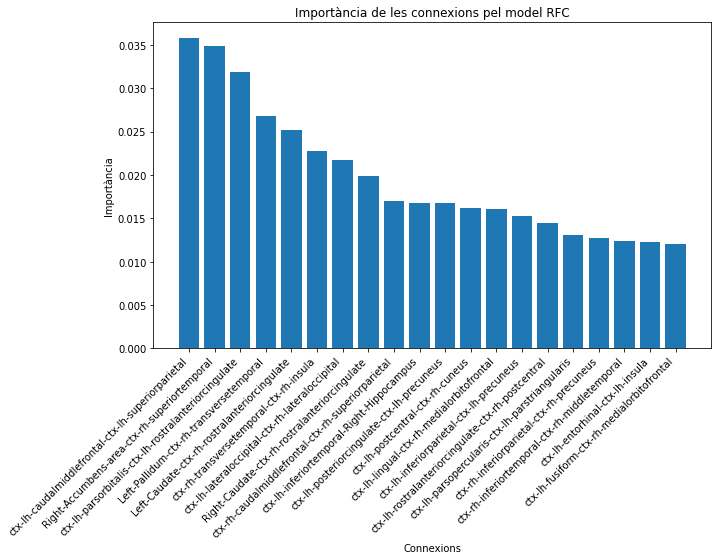

In [7]:
# ENTRENAMENT NOMÉS AMB LES CONNEXIONS SIGNIFICANTS (per Correcció de Bonferroni).
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix

# Divide data into Train and Testing set.
X_train, X_test, y_train, y_test = train_test_split(shuffled_df_model_data[llistat_columnes_analitzar], shuffled_df_model_data['controls_ms'], test_size=0.2, random_state=42)

# Display the shapes of the resulting sets.
print(f"Training set - Features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape} Labels: {y_test.shape}")

# RANDOM FOREST CLASSIFIER
# Create a Random Forest Classifier model.
model_RFC = RandomForestClassifier(random_state=42)

# Train the model using training data.
model_RFC.fit(X_train, y_train)

# Predict using Testing data.
y_pred = model_RFC.predict(X_test)

# Evaluate the model RFC.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Roc Curve
# Calcula la corba ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Dibuixa la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

dict_data_connexions = {f"{i}-{j}": f"{dict_data[str(i)]}-{dict_data[str(j)]}" for i in dict_data for j in dict_data}

# Obtenim la importancia de cada variable obtinguda pel model RFC.
importancia = model_RFC.feature_importances_

# Creem df d'importancia.
importancia_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importancia})

# Ordenem per importància.
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
importancia_df['Variable'] = importancia_df['Variable'].map(dict_data_connexions)

# Mostrem el plot de les variables i les seves importàncies
plt.figure(figsize=(10, 6))
plt.bar(importancia_df['Variable'][:20], importancia_df['Importancia'][:20])
plt.xlabel('Connexions')
plt.ylabel('Importància')
plt.title('Importància de les connexions pel model RFC')
plt.xticks(rotation=45, ha='right')
plt.show()

* **Connexions: SVM**

Training set - Features: (212, 126), Labels: (212,)
Testing set - Features: (53, 126) Labels: (53,)


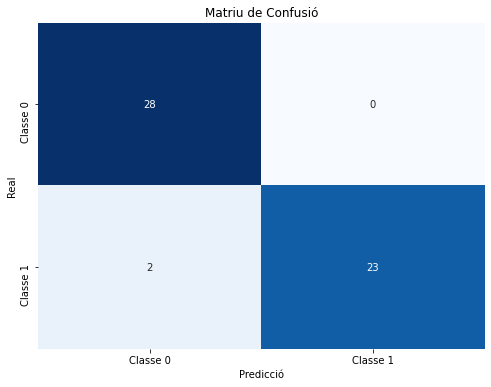

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.92      0.96        25

    accuracy                           0.96        53
   macro avg       0.97      0.96      0.96        53
weighted avg       0.96      0.96      0.96        53



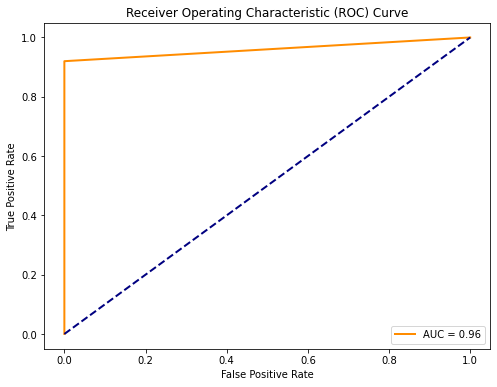

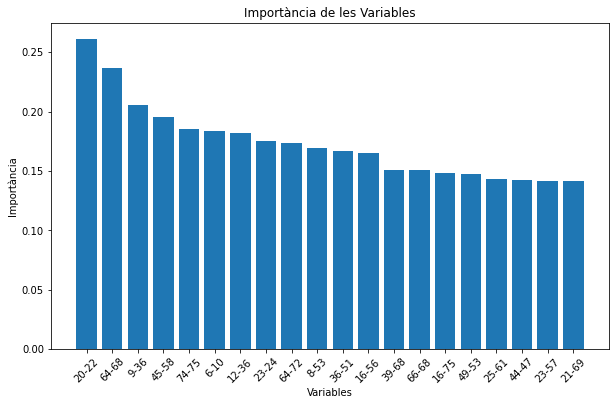

In [8]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

X_selected_cols = shuffled_df_model_data[llistat_columnes_analitzar]

# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(shuffled_df_model_data[llistat_columnes_analitzar], shuffled_df_model_data['controls_ms'], test_size=0.2, random_state=42)

print(f"Training set - Features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape} Labels: {y_test.shape}")

# Suppot Vector Machine (SVM).
# Creem el model de Suppor vector Machine.
model_SVM = SVC(kernel='linear')

# Entrenem el model utilitzant dades d'entrenament.
model_SVM.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_SVM.predict(X_test)

# Evaluem el model.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Obtenim la importancia de cada variable obtinguda pel model.
importancia = np.abs(model_SVM.coef_[0])

# Ordenem les importàncies i les variables corresponents.
indexes = np.argsort(importancia)[::-1]
feature_names = [llistat_columnes_analitzar[i] for i in range(X_selected_cols.shape[1])]

# Plot de la importància de cada variable.
plt.figure(figsize=(10, 6))
plt.bar(range(X_selected_cols.shape[1])[0:20], importancia[indexes][0:20], align='center')
plt.xticks(range(X_selected_cols.shape[1])[0:20], [feature_names[i] for i in indexes][0:20], rotation=45)
plt.xlabel('Variables')
plt.ylabel('Importància')
plt.title('Importància de les Variables')
plt.show()


* **Connexions: KNN**

Training set - Features: (212, 126), Labels: (212,)
Testing set - Features: (53, 126) Labels: (53,)


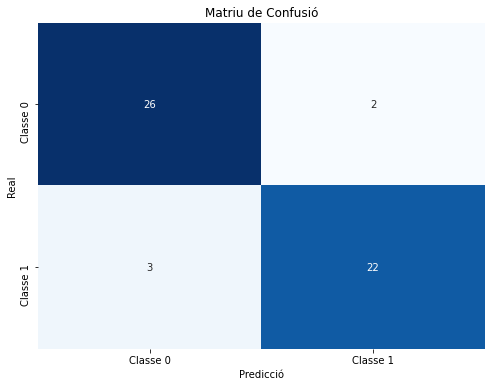

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.92      0.88      0.90        25

    accuracy                           0.91        53
   macro avg       0.91      0.90      0.91        53
weighted avg       0.91      0.91      0.91        53



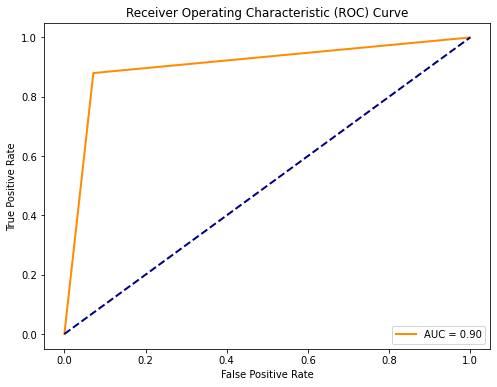

In [9]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

X_selected_cols = shuffled_df_model_data[llistat_columnes_analitzar]

# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(shuffled_df_model_data[llistat_columnes_analitzar], shuffled_df_model_data['controls_ms'], test_size=0.2, random_state=42)

print(f"Training set - Features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape} Labels: {y_test.shape}")

# KNN
# Se crea el modelo KNN.
model_KNN = KNeighborsClassifier(n_neighbors=2)

# Entrenem el model utilitzant dades d'entrenament.
model_KNN.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_KNN.predict(X_test)

# Evaluem el model KNN.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


* **Logistic Regression**

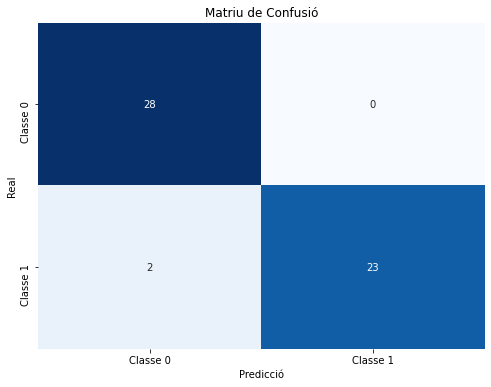

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.92      0.96        25

    accuracy                           0.96        53
   macro avg       0.97      0.96      0.96        53
weighted avg       0.96      0.96      0.96        53



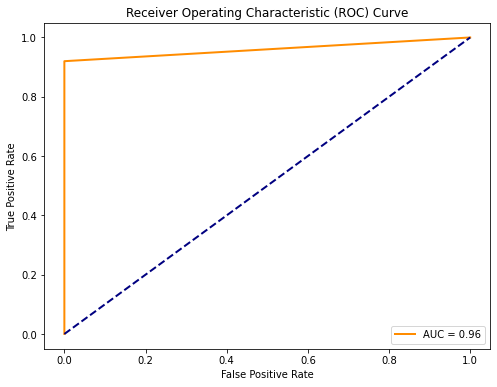

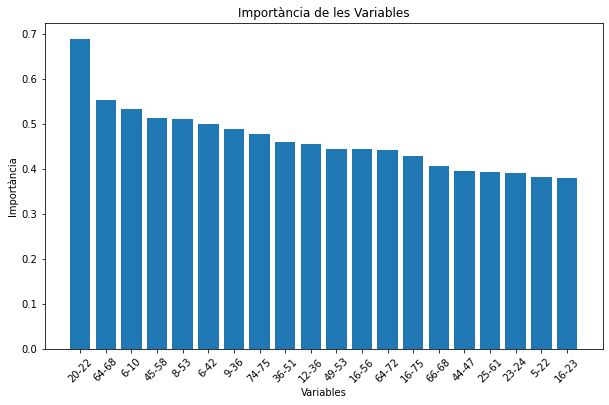

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

X_selected_cols = shuffled_df_model_data[llistat_columnes_analitzar]

# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(shuffled_df_model_data[llistat_columnes_analitzar], shuffled_df_model_data['controls_ms'], test_size=0.2, random_state=42)

# Logistic Regression
# Se crea el modelo Logistic Regression.
model_LR = LogisticRegression()

# Entrenem el model utilitzant dades d'entrenament.
model_LR.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_LR.predict(X_test)

# Evaluem el model Logistic Regression.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Obtenim la importancia de cada variable obtinguda pel model.
importancia = np.abs(model_LR.coef_[0])

# Ordenem les importàncies i les variables corresponents.
indexes = np.argsort(importancia)[::-1]
feature_names = [llistat_columnes_analitzar[i] for i in range(X_selected_cols.shape[1])]

# Plot de la importància de cada variable.
plt.figure(figsize=(10, 6))
plt.bar(range(X_selected_cols.shape[1])[:20], importancia[indexes][:20], align='center')
plt.xticks(range(X_selected_cols.shape[1])[:20], [feature_names[i] for i in indexes][:20], rotation=45)
plt.xlabel('Variables')
plt.ylabel('Importància')
plt.title('Importància de les Variables')
plt.show()


* **Connexions: GNB**

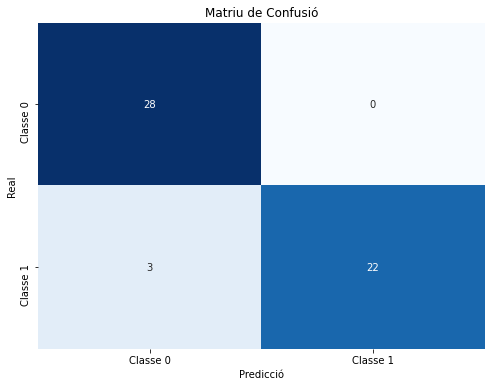

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       1.00      0.88      0.94        25

    accuracy                           0.94        53
   macro avg       0.95      0.94      0.94        53
weighted avg       0.95      0.94      0.94        53



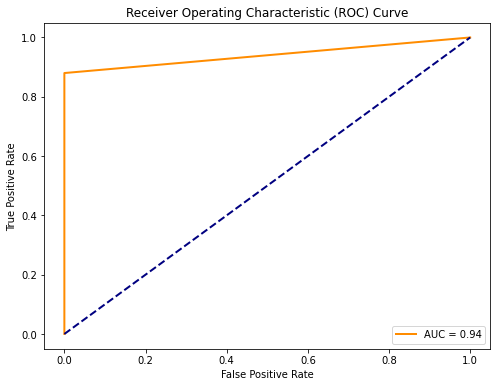

In [11]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

X_selected_cols = shuffled_df_model_data[llistat_columnes_analitzar]

# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(shuffled_df_model_data[llistat_columnes_analitzar], shuffled_df_model_data['controls_ms'], test_size=0.2, random_state=42)

# Gaussian Naive Bayes
# Se crea el modelo Gaussian Naive Bayes.
model_GNB = GaussianNB()

# Entrenem el model utilitzant dades d'entrenament.
model_GNB.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_GNB.predict(X_test)

# Evaluem el model Gaussian Naive Bayes.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [15]:
import networkx as nx
# Compare node 'metric' significance (NODE STRENGTH).
# Llegim la taula de metriques.
#table_structural_metrics = pd.read_csv(f'/home/guillem/Desktop/Data_Science/TFM/data/MULTILAYER/table_metrics_structural.csv')

#type_data = '_r_matrix.csv' # Functional data
type_data = '_FA_factor.csv' # Structural data
#type_data = '_GM_matrix.csv' # Morphological data

#folder_type = 'Functional'
folder_type = 'Structural'
#folder_type = 'Morphological'

patients_MS_strength = list()
controls_HV_strength = list()

# S'iteren totes les matrius.
for index, row in df.iterrows():
    # Llegim la matriu.
    matrix = pd.read_csv(
        f'/home/guillem/Desktop/Data_Science/TFM/data/MULTILAYER/test_Zeros_Undersampling/{folder_type}/{row["id"]}{type_data}', 
        header=None
    )
    matrix_array = np.array(matrix)
    
    # Creem el Graf a partir de la matriu.
    G = nx.from_numpy_matrix(matrix_array)
    
    # Calculem les metriques que volem.
    # Calculate node strength as the sum of edge weights
    node_strength = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes}
    #node_degree = dict(G.degree())
    
    if row['controls_ms'] == 1:
        patients_MS_strength.append(node_strength)
    else:
        controls_HV_strength.append(node_strength)
    
# NODE STRENGTH that have SIGNIFICANCE DIFFERENCE between MS and HV.
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def check_normality(data, alpha):
    _, p_value = shapiro(data)
    return p_value > alpha

nodes_strength_significative_difference = dict()
alpha = 0.05

# Iterem tots els nodes.
for node in range(0, 76):
    # Obtenim les dades del node iterat per HV i MS.
    data_MS = [patients_MS_strength[i][node] for i in range(0, len(patients_MS_strength))]
    data_HV = [controls_HV_strength[i][node] for i in range(0, len(controls_HV_strength))]
    
    normalitat_MS = check_normality(data_MS, alpha)
    normalitat_HV = check_normality(data_HV, alpha)
    #print("normalitat_MS:", normalitat_HV)
    # Realitza la prova U de Mann-Whitney (si MS i HV segueixen una distribució normal).
    if normalitat_MS and normalitat_HV:
        _, pvalue = ttest_ind(data_HV, data_MS)

    # Prova mostres independents.
    else:
        _, pvalue = mannwhitneyu(data_HV, data_MS, alternative='two-sided')
    
    if pvalue <= alpha:
        nodes_strength_significative_difference[node] = np.mean(data_MS)-np.mean(data_HV)

print("Nodes amb diferencies significatives en la Strength:", nodes_strength_significative_difference)


Nodes amb diferencies significatives en la Strength: {0: -5.033549509201102, 1: -2.053506238225225, 2: -5.727644656003093, 3: -3.993672517972925, 4: -2.958195279297172, 5: -3.179536524892768, 6: -1.9282575749270023, 7: -2.8057371250816345, 8: -5.822225904494047, 9: -2.2060883667426623, 10: -4.070015556301499, 11: -2.008905381223137, 12: -1.0936969561644645, 14: -3.1883467780797403, 15: -1.7001535260680356, 18: -2.1668554412626833, 19: -2.841622096523764, 20: -3.2810630339364977, 22: -1.6820575126011477, 24: -1.7580195036140864, 25: -1.0250486710154831, 26: -2.304422884742607, 27: -1.1271512120161162, 28: -1.4034759721108543, 29: -1.6547055135341004, 32: -1.0505636345259788, 33: 1.4308769933250005, 34: 1.1264959232542466, 35: -4.243618282775202, 36: -1.680653901678543, 38: 0.5539462358322211, 42: -2.3552150075101324, 43: -1.508829167520826, 45: -3.5564016961339746, 46: -1.6257869199480552, 47: -1.9664605821808578, 49: -1.1031473232662101, 50: -2.7630523472199187, 51: -2.1443788159920274

In [16]:
# GRAF WITH NODE NAMES
import numpy as np
import networkx as nx
from bokeh.models import Plot, Range1d, HoverTool, LabelSet, Circle, MultiLine, ColumnDataSource, Bezier
from bokeh.plotting import figure, show
from bokeh.models.graphs import from_networkx

# Creem el graf segons la matriu de significancia.
G = nx.from_numpy_matrix(significative_matrix)

# Afegim un atribut amb el nom de cada node.
node_names = {i: f"{dict_data[str(i)]}" for i in G.nodes()}
nx.set_node_attributes(G, node_names, 'node_name')

# Definim una funció custom per obtenir el color dels enllaços.
def edge_color_func(attribute):
    return 'red' if attribute['weight'] > 0 else 'blue'

# Afegim colors als enllaços.
for edge in G.edges(data=True):
    edge[2]['color'] = edge_color_func(edge[2])

# Creem un gràfic de Bokeh.
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5))
plot.title.text = "Connectogram Example"

# Renderitzem els grafs i els seus nodes.
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0, 0))
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color="white", line_color="black")
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color="white", line_color="black")
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color="white", line_color="black")

# Renderitzem els colors dels enllaços.
graph_renderer.edge_renderer.glyph = MultiLine(line_color={'field': 'color'}, line_alpha=0.8, line_width=0.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="firebrick", line_width=0.6)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color="navy", line_width=0.5)

# Afegim etiquetes als nodes
node_positions = nx.circular_layout(G)
source = {'x': [], 'y': [], 'labels': []}

for node, (x, y) in node_positions.items():
    source['x'].append(x)
    source['y'].append(y)
    source['labels'].append(node_names[node])

source = ColumnDataSource(data=source)
labels = LabelSet(x='x', y='y', text='labels', level='glyph', source=source, render_mode='canvas', text_baseline='top', text_align='center')

# Afegim línies corbes als enllaços
for edge in G.edges(data=True):
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2  # Punt mig com a control de la corba
    source = ColumnDataSource(data=dict(x=[x0, cx, x1], y=[y0, cy, y1]))
    curve_glyph = Bezier(line_color=edge[2]['color'], line_alpha=0.8, line_width=2.0)
    plot.add_glyph(source, curve_glyph)

# Renderització graf i nom dels nodes.
plot.renderers.append(graph_renderer)
plot.add_layout(labels)

hover = HoverTool(tooltips=[("Node", "@index")])
plot.add_tools(hover)

# Mostrem el gràfic.
show(plot)

In [17]:
# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE DIFFERENCE IN STRENGTH
import numpy as np
import networkx as nx
from bokeh.models import Plot, Range1d, HoverTool, LabelSet, Circle, MultiLine, ColumnDataSource, Bezier, Label
from bokeh.plotting import figure, show
from bokeh.models.graphs import from_networkx

# Assuming you have a list of nodes to color in red
dict_color_nodes = {dict_data[str(k)]: v for k,v in list(nodes_strength_significative_difference.items())}

# Creem el graf segons la matriu de significancia.
G = nx.from_numpy_matrix(significative_matrix)

# Afegim un atribut amb el nom de cada node.
node_names = {i: f"{dict_data[str(i)]}" for i in G.nodes()}
nx.set_node_attributes(G, node_names, 'node_name')

# Definim una funció custom per obtenir el color dels enllaços.
def edge_color_func(attribute):
    return 'red' if attribute['weight'] > 0 else 'blue'

# Afegim colors als enllaços.
for edge in G.edges(data=True):
    edge[2]['color'] = edge_color_func(edge[2])

# Creem un gràfic de Bokeh.
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5))
plot.title.text = "Connectogram Example"

# Renderitzem els grafs i els seus nodes.
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0, 0))

# Color nodes in red if they are in the list_color_nodes
node_indices = [G.nodes[node]['node_name'] for node in G.nodes()]
node_colors = list()
for node_index in node_indices:
    if node_index in dict_color_nodes:
        if dict_color_nodes[node_index] >= 0:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    else:
        node_colors.append('white')
#node_colors = ['red' if node_index in dict_color_nodes else 'white' for node_index in node_indices]

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.data_source.data['color'] = node_colors

graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")

# Renderitzem els colors dels enllaços.
graph_renderer.edge_renderer.glyph = MultiLine(line_color={'field': 'color'}, line_alpha=0.8, line_width=0.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="firebrick", line_width=0.6)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color="navy", line_width=0.5)

num_nodes = 76
angle_increment = 360/num_nodes

# Afegim etiquetes als nodes
node_positions = nx.circular_layout(G)
angles = {node: np.deg2rad(i * angle_increment) for i, (node, (x, y)) in enumerate(node_positions.items())}
label_positions = {node: (1.1 * np.cos(angle), 1.1 * np.sin(angle)) for node, angle in angles.items()}
source = {'x': [], 'y': [], 'labels': []}
label_source = {'x': [], 'y': [], 'labels': [], 'angles': []}


for node, (x, y) in label_positions.items():
    source['x'].append(x+0.10)
    source['y'].append(y+0.10)
    source['labels'].append(node_names[node])
    
    
    label_source['x'].append(x)
    label_source['y'].append(y)
    label_source['labels'].append(node_names[node])
    label_source['angles'].append(angles[node])
    
    #label = Label(x=x, y=y, text=str(node), render_mode='canvas', angle=angle, text_font_size='10pt', text_align='center')
    #label = Label(x=x, y=y, text=dict_data[str(node)], render_mode='canvas', angle=np.sin(angle_), text_font_size='10pt')
    #plot.add_layout(label)
    #angle_ += 180/76
    
source = ColumnDataSource(data=source)
label_source = ColumnDataSource(data=label_source)

# Add labels with an increasing angle
for x, y, label, angle in zip(label_source.data['x'], label_source.data['y'], label_source.data['labels'], label_source.data['angles']):
    label = Label(x=x, y=y, text=str(label), render_mode='canvas', angle=angle, text_font_size='10pt', text_align='left')
    plot.add_layout(label)
    
#labels = LabelSet(x='x', y='y', text='labels', angle=np.pi/4, level='glyph', source=source, render_mode='canvas')#, text_baseline='top', text_align='center')

# Afegim línies corbes als enllaços
for edge in G.edges(data=True):
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2  # Punt mig com a control de la corba
    source = ColumnDataSource(data=dict(x=[x0, cx, x1], y=[y0, cy, y1]))
    curve_glyph = Bezier(line_color=edge[2]['color'], line_alpha=0.8, line_width=2.0)
    plot.add_glyph(source, curve_glyph)

# Renderització graf i nom dels nodes.
plot.renderers.append(graph_renderer)
#plot.add_layout(labels, place="center")

hover = HoverTool(tooltips=[("Node", "@index")])
plot.add_tools(hover)

# Mostrem el gràfic.
show(plot)

### Visualització en 3D cerebral amb representació dels nodes

In [19]:
# Llegim el fitxer de coordenades dels nodes.
df_nodes_coordinates = pd.read_table('Node_mindboggle_default.node', header = None)
df_nodes_coordinates.rename(columns={0: "x", 1: "y", 2: "z", 5: "node_name"}, inplace = True)
df_nodes_coordinates.head()

,x,y,z,3,4,node_name
0,-4.28,16.90,28.3,2,1,ctx-lh-caudalanteriorcingulate
1,-35.20,12.00,46.5,3,1,ctx-lh-caudalmiddlefrontal
2,-6.44,-87.50,25.5,4,1,ctx-lh-cuneus
3,-22.20,-4.61,-35.8,5,1,ctx-lh-entorhinal
4,-33.30,-41.70,-21.6,6,1,ctx-lh-fusiform


In [20]:
# Construim el llistat de coordenades de cada node.
node_coordinates = list()

for i in range(0, 76):
    node_name = dict_data[str(i)]
    filtered_df = df_nodes_coordinates[df_nodes_coordinates['node_name'] == node_name]
    node_coordinates.append([float(filtered_df['x']), float(filtered_df['y']), float(filtered_df['z'])])
    

/home/guillem/.local/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()
/home/guillem/.local/lib/python3.6/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


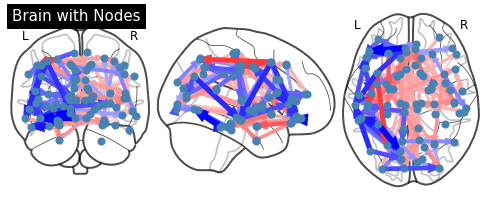

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, plotting
from nilearn.connectome import ConnectivityMeasure

# Visualització en 3D cerebral amb representació dels nodes.
plotting.plot_connectome(
    adjacency_matrix=np.array(significative_matrix),
    node_coords=node_coordinates,
    node_color='steelblue',
    title='Brain with Nodes',
    display_mode='ortho',
    annotate=True,
)
plt.show()

In [22]:
# COMPARACIÓ VOLUM DELS NODES (MS i HV).

In [23]:
# OBTENIM LA DIFERENCIA SIGNIFICATIVA EN EL VOLM DE NODES ENTRE MS i HV 
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def check_normality(data, alpha):
    _, p_value = shapiro(data)
    return p_value > alpha


nodes_volum_significative_difference = dict()
alpha = 0.05
num_matrius = 76

# Llegir excel Volum Nodes Controls.
volum_df_HV = pd.read_excel('VOLUM_NODES_CONTROLS.xls')

# Llegir excel Volum Nodes Pacients.
volum_df_MS = pd.read_excel('VOLUM_NODES_PATIENTS.xls')

llistat_nodes_volum = dict()

# Iterem tots els nodes.
for node in range(0, 76):
    node_name = dict_data[str(node)]
    
    # Obtenim les dades del node iterat per HV i MS.
    data_MS = list(volum_df_MS[node_name])
    data_HV = list(volum_df_HV[node_name])
    
    normalitat_MS = check_normality(data_MS, alpha)
    normalitat_HV = check_normality(data_HV, alpha)
    
    if normalitat_MS and normalitat_HV:
        _, pvalue = ttest_ind(data_HV, data_MS)

    # Prova mostres independents.
    else:
        _, pvalue = mannwhitneyu(data_HV, data_MS, alternative='two-sided')
    
    pvalue__corregit = pvalue*num_matrius
    
    if pvalue__corregit <= alpha:
        nodes_volum_significative_difference[node] = np.mean(data_MS)-np.mean(data_HV)
        

In [24]:
# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE DIFFERENCE IN VOLUM.
import numpy as np
import networkx as nx
from bokeh.models import Plot, Range1d, HoverTool, LabelSet, Circle, MultiLine, ColumnDataSource, Bezier
from bokeh.plotting import figure, show
from bokeh.models.graphs import from_networkx

# Assuming you have a list of nodes to color in red
dict_color_nodes = {dict_data[str(k)]: v for k,v in list(nodes_volum_significative_difference.items())}

# Creem el graf segons la matriu de significancia.
G = nx.from_numpy_matrix(significative_matrix)

# Afegim un atribut amb el nom de cada node.
node_names = {i: f"{dict_data[str(i)]}" for i in G.nodes()}
nx.set_node_attributes(G, node_names, 'node_name')

# Definim una funció custom per obtenir el color dels enllaços.
def edge_color_func(attribute):
    return 'red' if attribute['weight'] > 0 else 'blue'

# Afegim colors als enllaços.
for edge in G.edges(data=True):
    edge[2]['color'] = edge_color_func(edge[2])

# Creem un gràfic de Bokeh.
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5))
plot.title.text = "Connectogram Example"

# Renderitzem els grafs i els seus nodes.
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0, 0))

# Color nodes in red if they are in the list_color_nodes
node_indices = [G.nodes[node]['node_name'] for node in G.nodes()]
node_colors = list()
for node_index in node_indices:
    if node_index in dict_color_nodes:
        if dict_color_nodes[node_index] >= 0:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    else:
        node_colors.append('white')
#node_colors = ['red' if node_index in dict_color_nodes else 'white' for node_index in node_indices]

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.data_source.data['color'] = node_colors

graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")

# Renderitzem els colors dels enllaços.
graph_renderer.edge_renderer.glyph = MultiLine(line_color={'field': 'color'}, line_alpha=0.8, line_width=0.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="firebrick", line_width=0.6)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color="navy", line_width=0.5)

# Afegim etiquetes als nodes
node_positions = nx.circular_layout(G)
source = {'x': [], 'y': [], 'labels': []}

for node, (x, y) in node_positions.items():
    source['x'].append(x)
    source['y'].append(y)
    source['labels'].append(node_names[node])

source = ColumnDataSource(data=source)
labels = LabelSet(x='x', y='y', text='labels', level='glyph', source=source, render_mode='canvas', text_baseline='top', text_align='center')

# Afegim línies corbes als enllaços
for edge in G.edges(data=True):
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2  # Punt mig com a control de la corba
    source = ColumnDataSource(data=dict(x=[x0, cx, x1], y=[y0, cy, y1]))
    curve_glyph = Bezier(line_color=edge[2]['color'], line_alpha=0.8, line_width=2.0)
    plot.add_glyph(source, curve_glyph)

# Renderització graf i nom dels nodes.
plot.renderers.append(graph_renderer)
plot.add_layout(labels)

hover = HoverTool(tooltips=[("Node", "@index")])
plot.add_tools(hover)

# Mostrem el gràfic.
show(plot)

### Correlació entre Connexions i Tests Cognitius

In [194]:
# Correlació de NODE x Test Cognitiu.

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Creem columna al dataframe per cada node.
for i in range(0, 76):
    df[f'mean_FA_{dict_data[str(i)]}'] = None
    
# Afegim el valor de mitjana FA de cada node.
for index, row in df.iterrows():
    # Iterem tots els nodes.
    for node in range(0, 76):
        # Per cada node obtenim la mitjana de FA.
        mean_FA = np.mean(np.array(row['matrix'])[node])
        
        df.at[index, f'mean_FA_{dict_data[str(node)]}'] = mean_FA


In [26]:
# Obtenim les columnes per dur a terme l'anàlisi de correlacions.
df_node_columns = pd.DataFrame(df[list(df.filter(like="mean_FA_").columns) + ['zattention']])

# Eliminem els na de la columna 'zattention'.
df_node_columns = df_node_columns.dropna(subset=['zattention'])

# Creem un DataFrame buit, per afegir les correlacions.
correlation_with_zattention = pd.DataFrame(index=['correlation', 'pvalue'], columns=[col.replace('mean_FA_', '') for col in df_node_columns.columns[:-1]])

correlation_selected_columns_zattention = list()
# Calculem les correlacions per cada node amb la columna 'zattention'.
for column in df_node_columns.columns[:-1]:
    correlation_coef, pvalue = pearsonr(df_node_columns[column], df_node_columns['zattention'])
    if pvalue <= 0.05:
        correlation_with_zattention.loc['correlation', column] = correlation_coef
        correlation_with_zattention.loc['pvalue', column] = pvalue
        correlation_selected_columns_zattention.append(column.replace('mean_FA_', ''))
        

# Mostrem els resultats.
print(f"Nodes a analitzar: {correlation_selected_columns_zattention}")
print("Correlation with 'zattention':")
correlation_with_zattention.head()


Nodes a analitzar: ['ctx-lh-caudalanteriorcingulate', 'ctx-lh-precentral', 'ctx-lh-rostralanteriorcingulate', 'ctx-rh-rostralmiddlefrontal']
Correlation with 'zattention':


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,ctx-lh-lateralorbitofrontal,...,ctx-rh-superiorfrontal,ctx-rh-superiorparietal,ctx-rh-superiortemporal,ctx-rh-supramarginal,ctx-rh-transversetemporal,ctx-rh-insula,mean_FA_ctx-lh-caudalanteriorcingulate,mean_FA_ctx-lh-precentral,mean_FA_ctx-lh-rostralanteriorcingulate,mean_FA_ctx-rh-rostralmiddlefrontal
correlation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256131,0.262364,-0.261653,0.252007
pvalue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.044496,0.039394,0.039950,0.048162


In [27]:
dict_color_nodes_correlation_zattention = dict()

for node in correlation_with_zattention: # correlation_selected_columns_zattention # (list())
    if correlation_with_zattention[node]['pvalue'] <= 0.05:
        dict_color_nodes_correlation_zattention[node.replace('mean_FA_', '')] = correlation_with_zattention[node]['correlation']

dict_color_nodes_correlation_zattention

{'ctx-lh-caudalanteriorcingulate': 0.25613100987276866,
 'ctx-lh-precentral': 0.2623637445322739,
 'ctx-lh-rostralanteriorcingulate': -0.2616530273354041,
 'ctx-rh-rostralmiddlefrontal': 0.2520065626557868}

In [28]:
# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE CORRELATIONS (POSITIVE 'red', NEGATIVE 'blue').
import numpy as np
import networkx as nx
from bokeh.models import Plot, Range1d, HoverTool, LabelSet, Circle, MultiLine, ColumnDataSource, Bezier, Label
from bokeh.plotting import figure, show
from bokeh.models.graphs import from_networkx

# Assuming you have a list of nodes to color in red
dict_color_nodes = {dict_data[str(k)]: v for k,v in list(nodes_strength_significative_difference.items())}

# Creem el graf segons la matriu de significancia.
G = nx.from_numpy_matrix(significative_matrix)

# Afegim un atribut amb el nom de cada node.
node_names = {i: f"{dict_data[str(i)]}" for i in G.nodes()}
nx.set_node_attributes(G, node_names, 'node_name')

# Definim una funció custom per obtenir el color dels enllaços.
def edge_color_func(attribute):
    return 'red' if attribute['weight'] > 0 else 'blue'

# Afegim colors als enllaços.
for edge in G.edges(data=True):
    edge[2]['color'] = edge_color_func(edge[2])

# Creem un gràfic de Bokeh.
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5))
plot.title.text = "Connectogram Example"

# Renderitzem els grafs i els seus nodes.
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0, 0))

# Color nodes in red if they are in the list_color_nodes
node_indices = [G.nodes[node]['node_name'] for node in G.nodes()]
node_colors = list()
for node_index in node_indices:
    if node_index in dict_color_nodes:
        if dict_color_nodes[node_index] >= 0:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    else:
        node_colors.append('white')

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.data_source.data['color'] = node_colors

graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")

# Renderitzem els colors dels enllaços.
graph_renderer.edge_renderer.glyph = MultiLine(line_color={'field': 'color'}, line_alpha=0.8, line_width=0.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="firebrick", line_width=0.6)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color="navy", line_width=0.5)

num_nodes = 76
angle_increment = 360/num_nodes

# Afegim etiquetes als nodes
node_positions = nx.circular_layout(G)
angles = {node: np.deg2rad(i * angle_increment) for i, (node, (x, y)) in enumerate(node_positions.items())}
label_positions = {node: (1.1 * np.cos(angle), 1.1 * np.sin(angle)) for node, angle in angles.items()}
label_source = {'x': [], 'y': [], 'labels': [], 'angles': []}


for node, (x, y) in label_positions.items():
    label_source['x'].append(x)
    label_source['y'].append(y)
    label_source['labels'].append(node_names[node])
    label_source['angles'].append(angles[node])
    

label_source = ColumnDataSource(data=label_source)

# Add labels with an increasing angle
for x, y, label, angle in zip(label_source.data['x'], label_source.data['y'], label_source.data['labels'], label_source.data['angles']):
    label = Label(x=x, y=y, text=str(label), render_mode='canvas', angle=angle, text_font_size='10pt', text_align='left')
    plot.add_layout(label)
    
# Afegim línies corbes als enllaços
for edge in G.edges(data=True):
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2  # Punt mig com a control de la corba
    source = ColumnDataSource(data=dict(x=[x0, cx, x1], y=[y0, cy, y1]))
    curve_glyph = Bezier(line_color=edge[2]['color'], line_alpha=0.8, line_width=2.0)
    plot.add_glyph(source, curve_glyph)

# Renderització graf i nom dels nodes.
plot.renderers.append(graph_renderer)

hover = HoverTool(tooltips=[("Node", "@index")])
plot.add_tools(hover)

# Mostrem el gràfic.
show(plot)

### Correlació entre connexions i zattention.

In [29]:
df_zattention_edges = df[df['zattention'].notna()]
df_zattention_edges = df_zattention_edges[['matrix', 'zattention']]
df_zattention_edges

,matrix,zattention
72,0 1 2 3 4 ...,-0.8170
94,0 1 2 3 4 ...,1.9872
95,0 1 2 3 4 ...,-2.5714
96,0 1 2 3 4...,-1.7292
97,0 1 2 3 4 ...,-0.9955
...,...,...
151,0 1 2 3 4 ...,0.5357
152,0 1 2 3 4...,-0.1072
153,0 1 2 3 4...,-0.4137
154,0 1 2 3 ...,0.8254


In [30]:
from scipy.stats import pearsonr

# Correlació entre connexions i zattention.
alpha = 0.05
num_matrius = len(df_zattention_edges)

# Creem un DataFrame buit, per afegir les correlacions.
correlation_matrix_zattention = np.zeros((76, 76))

correlation_selected_columns_zattention_edges = list()

# Se iteran todos los nodos.
for i in range(0, 76):
    # Se iteran todos los nodos para comparar.
    for j in range(i, 76):
        connexions = [matrix[i][j] for matrix in df_zattention_edges['matrix']]
        attention = [at for at in df_zattention_edges['zattention']]
        
        # Calculem la correlació entre totes les connexions 'i-j' amb 'zattention'.
        statistic, pvalue = pearsonr(connexions, attention)      
        
        # Apliquem la correció de bonferroni.
        #pvalue_corregit = pvalue*num_matrius
        
        # Si el pvalue es menor que 0.05.
        if pvalue <= alpha:
            correlation_matrix_zattention[i][j] = statistic
            llistat_columnes_analitzar.append(f"{i}-{j}")
            

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [31]:
# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE DIFFERENCE IN STRENGTH
# AND EDGES WITH SIGNIFICANT CORRELATION WITH ZATTENTION.
import numpy as np
import networkx as nx
from bokeh.models import Plot, Range1d, HoverTool, LabelSet, Circle, MultiLine, ColumnDataSource, Bezier, Label
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.graphs import from_networkx

# Assuming you have a list of nodes to color in red
dict_color_nodes = {dict_data[str(k)]: v for k, v in list(nodes_strength_significative_difference.items())}

# Creem el graf segons la matriu de significancia.
G = nx.from_numpy_matrix(correlation_matrix_zattention)

# Afegim un atribut amb el nom de cada node.
node_names = {i: f"{dict_data[str(i)]}" for i in G.nodes()}
nx.set_node_attributes(G, node_names, 'node_name')

# Definim una funció custom per obtenir el color dels enllaços.
def edge_color_func(attribute):
    return 'red' if attribute['weight'] > 0 else 'blue'

# Afegim colors als enllaços.
for edge in G.edges(data=True):
    edge[2]['color'] = edge_color_func(edge[2])

# Creem un gràfic de Bokeh.
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5))
plot.title.text = "Connectogram Example"

# Renderitzem els grafs i els seus nodes.
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0, 0))

# Color nodes in red if they are in the list_color_nodes
node_indices = [G.nodes[node]['node_name'] for node in G.nodes()]
node_colors = list()
for node_index in node_indices:
    if node_index in dict_color_nodes:
        if dict_color_nodes[node_index] >= 0:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    else:
        node_colors.append('white')

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.data_source.data['color'] = node_colors

graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")

# Renderitzem els colors dels enllaços.
graph_renderer.edge_renderer.glyph = MultiLine(line_color={'field': 'color'}, line_alpha=0.8, line_width=0.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="firebrick", line_width=0.6)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color="navy", line_width=0.5)

num_nodes = 76
angle_increment = 360/num_nodes

# Afegim etiquetes als nodes
node_positions = nx.circular_layout(G)
angles = {node: np.deg2rad(i * angle_increment) for i, (node, (x, y)) in enumerate(node_positions.items())}
label_positions = {node: (1.1 * np.cos(angle), 1.1 * np.sin(angle)) for node, angle in angles.items()}
label_source = {'x': [], 'y': [], 'labels': [], 'angles': []}

for node, (x, y) in label_positions.items():
    label_source['x'].append(x)
    label_source['y'].append(y)
    label_source['labels'].append(node_names[node])
    label_source['angles'].append(angles[node])

label_source = ColumnDataSource(data=label_source)

# Add labels with an increasing angle
for x, y, label, angle in zip(label_source.data['x'], label_source.data['y'], label_source.data['labels'], label_source.data['angles']):
    label = Label(x=x, y=y, text=str(label), render_mode='canvas', angle=angle, text_font_size='10pt', text_align='left')
    plot.add_layout(label)
    
# Afegim línies corbes als enllaços
for edge in G.edges(data=True):
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    cx, cy = (x0+x1)/2, (y0+y1)/2
    source = ColumnDataSource(data=dict(x=[x0, cx, x1], y=[y0, cy, y1]))
    curve_glyph = Bezier(line_color=edge[2]['color'], line_alpha=0.8, line_width=2.0)
    plot.add_glyph(source, curve_glyph)

# Renderització graf i nom dels nodes.
plot.renderers.append(graph_renderer)
#plot.add_layout(labels, place="center")

hover = HoverTool(tooltips=[("Node", "@index")])
plot.add_tools(hover)

# Mostrem el gràfic.
show(plot)

In [32]:
print(f"Valor Minim 'zattention': {min(list(df[df['zattention'].notna()]['zattention']))}")
print(f"Valor Màxim 'zattention': {max(list(df[df['zattention'].notna()]['zattention']))}")
print("Per tant, observem connexions amb diferencies significatives en la correlació. Que indiquen una correlació negativa (connexió blava) o una correlació positiva (vermella), que per tant, ens fan observar que hi ha connexions específiques que poden contribuir tant positivament com negativament en la puntuació de attenció.")

Valor Minim 'zattention': -3.2143
Valor Màxim 'zattention': 1.9872
Per tant, observem connexions amb diferencies significatives en la correlació. Que indiquen una correlació negativa (connexió blava) o una correlació positiva (vermella), que per tant, ens fan observar que hi ha connexions específiques que poden contribuir tant positivament com negativament en la puntuació de attenció.


* **Correlacions especifiques entre connexions i zscore, etc**

In [33]:
# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE DIFFERENCE IN STRENGTH
# AND EDGES WITH SIGNIFICANT CORRELATION WITH SDMT (Funció Cognitiva).
# SDMT: mesura la velocitat de processament de la informació i l'atenció
df_zscore_edges = df[df['sdmt'].notna()]
df_zscore_edges = df_zscore_edges[['matrix', 'sdmt']]


from scipy.stats import pearsonr

# Correlació entre connexions i zattention.
alpha = 0.05
num_matrius = len(df_zscore_edges)

# Creem un DataFrame buit, per afegir les correlacions.
correlation_matrix_zscore = np.zeros((76, 76))

correlation_selected_columns_zscore_edges = list()
llistat_columnes_analitzar = list()

# Se iteran todos los nodos.
for i in range(0, 76):
    # Se iteran todos los nodos para comparar.
    for j in range(i, 76):
        connexions = [matrix[i][j] for matrix in df_zscore_edges['matrix']]
        score = [at for at in df_zscore_edges['sdmt']]
        
        # Calculem la correlació entre totes les connexions 'i-j' amb 'zattention'.
        statistic, pvalue = pearsonr(connexions, score)      
        
        # Apliquem la correció de bonferroni.
        #pvalue_corregit = pvalue*num_matrius
        
        # Si el pvalue es menor que 0.05.
        if pvalue <= alpha:
            correlation_matrix_zscore[i][j] = statistic
            llistat_columnes_analitzar.append(f"{i}-{j}")

# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE DIFFERENCE IN STRENGTH
# AND EDGES WITH SIGNIFICANT CORRELATION WITH ZSCORE.
import numpy as np
import networkx as nx
from bokeh.models import Plot, Range1d, HoverTool, LabelSet, Circle, MultiLine, ColumnDataSource, Bezier, Label
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.graphs import from_networkx

# Assuming you have a list of nodes to color in red
dict_color_nodes = {dict_data[str(k)]: v for k, v in list(nodes_strength_significative_difference.items())}

# Creem el graf segons la matriu de significancia.
G = nx.from_numpy_matrix(correlation_matrix_zscore)

# Afegim un atribut amb el nom de cada node.
node_names = {i: f"{dict_data[str(i)]}" for i in G.nodes()}
nx.set_node_attributes(G, node_names, 'node_name')

# Definim una funció custom per obtenir el color dels enllaços.
def edge_color_func(attribute):
    return 'red' if attribute['weight'] > 0 else 'blue'

# Afegim colors als enllaços.
for edge in G.edges(data=True):
    edge[2]['color'] = edge_color_func(edge[2])

# Creem un gràfic de Bokeh.
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5))
plot.title.text = "Connectogram Example"

# Renderitzem els grafs i els seus nodes.
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0, 0))

# Color nodes in red if they are in the list_color_nodes
node_indices = [G.nodes[node]['node_name'] for node in G.nodes()]
node_colors = list()
for node_index in node_indices:
    if node_index in dict_color_nodes:
        if dict_color_nodes[node_index] >= 0:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    else:
        node_colors.append('white')

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.data_source.data['color'] = node_colors

graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")

# Renderitzem els colors dels enllaços.
graph_renderer.edge_renderer.glyph = MultiLine(line_color={'field': 'color'}, line_alpha=0.8, line_width=0.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="firebrick", line_width=0.6)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color="navy", line_width=0.5)

num_nodes = 76
angle_increment = 360/num_nodes

# Afegim etiquetes als nodes
node_positions = nx.circular_layout(G)
angles = {node: np.deg2rad(i * angle_increment) for i, (node, (x, y)) in enumerate(node_positions.items())}
label_positions = {node: (1.1 * np.cos(angle), 1.1 * np.sin(angle)) for node, angle in angles.items()}
label_source = {'x': [], 'y': [], 'labels': [], 'angles': []}

for node, (x, y) in label_positions.items():
    label_source['x'].append(x)
    label_source['y'].append(y)
    label_source['labels'].append(node_names[node])
    label_source['angles'].append(angles[node])

label_source = ColumnDataSource(data=label_source)

# Add labels with an increasing angle
for x, y, label, angle in zip(label_source.data['x'], label_source.data['y'], label_source.data['labels'], label_source.data['angles']):
    label = Label(x=x, y=y, text=str(label), render_mode='canvas', angle=angle, text_font_size='10pt', text_align='left')
    plot.add_layout(label)
    
# Afegim línies corbes als enllaços
for edge in G.edges(data=True):
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2 
    source = ColumnDataSource(data=dict(x=[x0, cx, x1], y=[y0, cy, y1]))
    curve_glyph = Bezier(line_color=edge[2]['color'], line_alpha=0.8, line_width=2.0)
    plot.add_glyph(source, curve_glyph)

# Renderització graf i nom dels nodes.
plot.renderers.append(graph_renderer)

hover = HoverTool(tooltips=[("Node", "@index")])
plot.add_tools(hover)

# Mostrem el gràfic.
show(plot)
            

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [34]:
# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE DIFFERENCE IN STRENGTH
# AND EDGES WITH SIGNIFICANT CORRELATION WITH PASAT (Funció Cognitiva).
# PASAT: avalua la velocitat de càlcul i la memòria de treball.

df_zscore_edges = df[df['pasat'].notna()]
df_zscore_edges = df_zscore_edges[['matrix', 'pasat']]


from scipy.stats import pearsonr

# Correlació entre connexions i zattention.
alpha = 0.05
num_matrius = len(df_zscore_edges)

# Creem un DataFrame buit, per afegir les correlacions.
correlation_matrix_zscore = np.zeros((76, 76))

correlation_selected_columns_zscore_edges = list()
llistat_columnes_analitzar = list()

# Se iteran todos los nodos.
for i in range(0, 76):
    # Se iteran todos los nodos para comparar.
    for j in range(i, 76):
        connexions = [matrix[i][j] for matrix in df_zscore_edges['matrix']]
        score = [at for at in df_zscore_edges['pasat']]
        
        # Calculem la correlació entre totes les connexions 'i-j' amb 'zattention'.
        statistic, pvalue = pearsonr(connexions, score)      
        
        # Apliquem la correció de bonferroni.
        #pvalue_corregit = pvalue*num_matrius
        
        # Si el pvalue es menor que 0.05.
        if pvalue <= alpha:
            correlation_matrix_zscore[i][j] = statistic
            llistat_columnes_analitzar.append(f"{i}-{j}")

# GRAF WITH NODE NAMES AND COLORING NODES WITH SIGNIFICATIVE DIFFERENCE IN STRENGTH
# AND EDGES WITH SIGNIFICANT CORRELATION WITH ZSCORE.
import numpy as np
import networkx as nx
from bokeh.models import Plot, Range1d, HoverTool, LabelSet, Circle, MultiLine, ColumnDataSource, Bezier, Label
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.graphs import from_networkx

# Assuming you have a list of nodes to color in red
dict_color_nodes = {dict_data[str(k)]: v for k, v in list(nodes_strength_significative_difference.items())}

# Creem el graf segons la matriu de significancia.
G = nx.from_numpy_matrix(correlation_matrix_zscore)

# Afegim un atribut amb el nom de cada node.
node_names = {i: f"{dict_data[str(i)]}" for i in G.nodes()}
nx.set_node_attributes(G, node_names, 'node_name')

# Definim una funció custom per obtenir el color dels enllaços.
def edge_color_func(attribute):
    return 'red' if attribute['weight'] > 0 else 'blue'

# Afegim colors als enllaços.
for edge in G.edges(data=True):
    edge[2]['color'] = edge_color_func(edge[2])

# Creem un gràfic de Bokeh.
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5))
plot.title.text = "Connectogram Example"

# Renderitzem els grafs i els seus nodes.
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0, 0))

# Color nodes in red if they are in the list_color_nodes
node_indices = [G.nodes[node]['node_name'] for node in G.nodes()]
node_colors = list()
for node_index in node_indices:
    if node_index in dict_color_nodes:
        if dict_color_nodes[node_index] >= 0:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    else:
        node_colors.append('white')

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.data_source.data['color'] = node_colors

graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color={'field': 'color'}, line_color="black")

# Renderitzem els colors dels enllaços.
graph_renderer.edge_renderer.glyph = MultiLine(line_color={'field': 'color'}, line_alpha=0.8, line_width=0.5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="firebrick", line_width=0.6)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color="navy", line_width=0.5)

num_nodes = 76
angle_increment = 360/num_nodes

# Afegim etiquetes als nodes
node_positions = nx.circular_layout(G)
angles = {node: np.deg2rad(i * angle_increment) for i, (node, (x, y)) in enumerate(node_positions.items())}
label_positions = {node: (1.1 * np.cos(angle), 1.1 * np.sin(angle)) for node, angle in angles.items()}
label_source = {'x': [], 'y': [], 'labels': [], 'angles': []}

for node, (x, y) in label_positions.items():
    label_source['x'].append(x)
    label_source['y'].append(y)
    label_source['labels'].append(node_names[node])
    label_source['angles'].append(angles[node])

label_source = ColumnDataSource(data=label_source)

# Add labels with an increasing angle
for x, y, label, angle in zip(label_source.data['x'], label_source.data['y'], label_source.data['labels'], label_source.data['angles']):
    label = Label(x=x, y=y, text=str(label), render_mode='canvas', angle=angle, text_font_size='10pt', text_align='left')
    plot.add_layout(label)
    
# Afegim línies corbes als enllaços
for edge in G.edges(data=True):
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2 
    source = ColumnDataSource(data=dict(x=[x0, cx, x1], y=[y0, cy, y1]))
    curve_glyph = Bezier(line_color=edge[2]['color'], line_alpha=0.8, line_width=2.0)
    plot.add_glyph(source, curve_glyph)

# Renderització graf i nom dels nodes.
plot.renderers.append(graph_renderer)

hover = HoverTool(tooltips=[("Node", "@index")])
plot.add_tools(hover)

# Mostrem el gràfic.
show(plot)
            

/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/home/guillem/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "


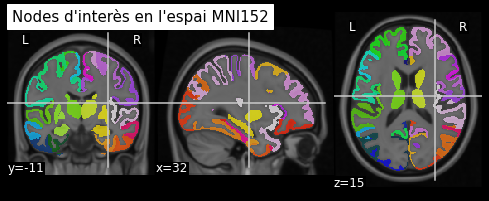

In [312]:
import nibabel as nib
from nilearn import plotting, image

# Carregar la imatge T1w.
imatge_T1w = nib.load('MNI152_T1_1mm_N4.nii.gz')

# Carregar els nodes d'interès.
nodes_mindboggle = nib.load('nodes_mindboggle.nii.gz')

# Normalització de la imatge T1w a l'espai MNI152.
imatge_T1w_mni = image.resample_to_img(imatge_T1w, nodes_mindboggle)

# Visualitzar la imatge T1w amb els nodes d'interès.
plotting.plot_roi(nodes_mindboggle, bg_img=imatge_T1w_mni, title='Nodes d\'interès en l\'espai MNI152')

# Mostrar la visualització.
plotting.show()

Min value of the image data: 0.0
Mean value of the image data: 3.4231302395557863
Max value of the image data: 76.0


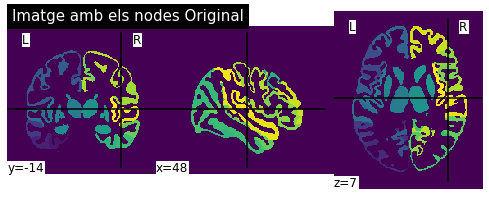

In [279]:
import nibabel as nib
from nilearn import plotting

# Carreguem la imatge NIfTI amb els nodes.
nodes_nifti_img = nib.load('nodes_mindboggle.nii.gz')

# Convertim les dades a al tipus array.
nodes_data_array = nodes_nifti_img.get_fdata()

min_value = nodes_data_array.min()
mean_value = nodes_data_array.mean()
max_value = nodes_data_array.max()

print(f'Min value of the image data: {min_value}')
print(f'Mean value of the image data: {mean_value}')
print(f'Max value of the image data: {max_value}')

# Observem la imatge NifTI image.
plotting.plot_img(nifti_img, title='Imatge amb els nodes Original')
plotting.show()